# Fit data from Fermi/GBM - Aug 30 2022
A partially-occulted flare was observed by Fermi/GBM on August 30 2022 at approximately 17:50 UTC.

This example shows how to:

0. Install prerequesite non-Python packages (for Unix machines)
1. Visualize Fermi/GBM detectors at this time (and pick one which is sunward, but not piled-up)
2. Generate a set of response matrices for that data
3. Load and visualize the Fermi CSPEC data using the [`astro-gdt-fermi`](https://astro-gdt.readthedocs.io/projects/astro-gdt-fermi/en/latest/) toolset
4. Load and select the appropriate response matrix for the analysis interval
    - As part of this step, we rebin both the data and SRM using the Gamma-ray Data Tools
6. Fit the data with solar physics functions (thermal bremsstrahlung + photon power law)

## Step 0: install non-Python packages
Some of the Fermi tools require additional packages.

### Packages for the response generator
The Fermi/GBM response matrix generator is basically an interpolater of Geant4 data files, which are stored as FITS.
You require the `cfitsio` development package, `gcc`, CMake, and a Perl installation.

Follow the installation instructions from the Fermi response generator website,
found [here](https://fermi.gsfc.nasa.gov/ssc/data/analysis/rmfit/INSTALL.html).
You need to download the tarball and install the program following its directions.
In addition to the tarball instructions, I had to run
```bash
# Ubuntu/Debian example installation line
sudo apt install libastro-fits-header-perl libcfitsio-bin libccfits-dev
```

### Initializing the `astro-gdt-fermi` package
You need to initialize the `astro-gdt-fermi` package after installing it.
To install it,
    install `yaff[examples]`,
    and the tool will be part of that installation.
Then run, in a shell
```sh
gdt-data init
```

## Step 1: find which detector we should use
To find an appropriate detector,
    we need an event time,
    and then we can visualize the Fermi/GBM detectors on the sky.

For the event analyzed in this notebook,
    we can get the position history (`poshist`) file off of the Fermi/GBM
    FTP server:
```bash
wget https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/daily/2022/08/30/current/glg_poshist_all_220830_v00.fit
```

Then, we use Python to plot the detectors at a specified time.

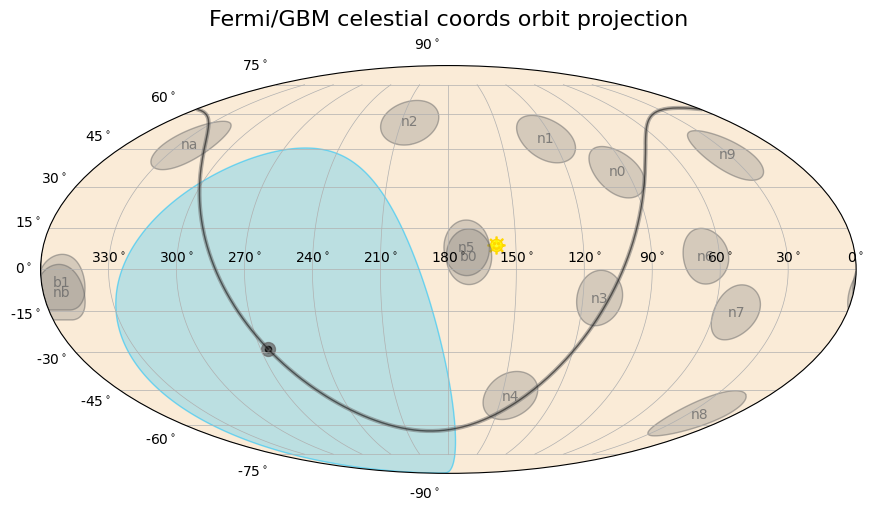

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import astropy.time as atime
from gdt.core.plot.sky import EquatorialPlot
from gdt.missions.fermi.gbm.poshist import GbmPosHist

%matplotlib inline
plt.style.use("nice.mplstyle")

event_time = atime.Time("2022-08-30T17:52:00")
poshist_file = "glg_poshist_all_220830_v00.fit"

ph = GbmPosHist.open(poshist_file)

frame = ph.get_spacecraft_frame()
my_frame = frame.at(event_time)

eqplot = EquatorialPlot()
eqplot.add_frame(my_frame)
fig = plt.gcf()
fig.suptitle("Fermi/GBM celestial coords orbit projection")
plt.show()

## Step 2: generate response matrices

From the equatorial plot, we can see that detector `n5` is pointing straight at the Sun.
From prior analysis,
    we know that detector is severely piled-up.
A better choice is detector `n4`. So, let's download the data for that detector.

We also need to know the solar flare's position in right ascension (RA) and declination (dec) relative to Fermi,
    in [GCRS](https://en.wikipedia.org/wiki/Barycentric_and_geocentric_celestial_reference_systems),
    for the response matrix generation.
In the case of the Sun, the difference in angular location between the flare and the Sun's center is negligible.
So, we just take the Sun's center coordinate via `astropy.coordinates.get_sun`.

Finally,
    we need to know the Fermi mission times corresponding to the UTC bounding box we care about.
This can be achieved using the gamma-ray data tools.

In [2]:
from astropy import coordinates
from astropy import units as u

sun_coord = coordinates.get_sun(event_time).transform_to("gcrs")

ra, dec = sun_coord.ra, sun_coord.dec
# Print the RA and Dec in the format required by the Perl script
print(f"-R{ra.to_value(u.deg):.2f} -D{dec.to_value(u.deg):.2f}")

-R158.75 -D8.93


In [3]:
# Finally, get the mission times of the event
from astropy import time as atime
from gdt.missions.fermi.time import *

# Time range which contains most of the flare
ta = atime.Time("2022-08-30T17:30:00")
tb = atime.Time("2022-08-30T18:30:00")

# Print the values in mission time for the response generator
ta_fermi, tb_fermi = int(ta.to_value("fermi")), int(tb.to_value("fermi"))

# The print statement formats them as the arguments required to the response Perl script
print(f"-S{ta_fermi} -E{tb_fermi}")

-S683573405 -E683577005


Now we can generate the response matrix files using the Perl script installed earlier, `SA_GBM_RSP_Gen.pl`.
For this to work, we need both the `.pha` and position history files.
Here is a quick shell snippet that does what we want, along with some helpful comments:
```bash
mkdir -p fermi-responses
# Go into the folder
pushd fermi-responses

# Bring the position (orbit) history file from one directory up into this folder
cp ../glg_poshist* .
# Get the data associated with detector 4 from the web
wget https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/daily/2022/08/30/current/glg_cspec_n4_220830_v00.pha

# Run the SA_GBM_RSP_Gen script; for argument descriptions,
# open the script in a text editor and read the block comment at the top.
# We use the RA and Dec determined above.
# The start and end times are Fermi mission times generated from the range of interest, above
SA_GBM_RSP_Gen.pl -Ccspec -S683573405 -E683577005 -R158.75 -D8.93 -OFLARE -V0 ./

# Go back to the original directory
popd
```

If all goes smoothly, you should see something like this at the last few lines of output:

```text
Det, det_az, det_zen:            4   303.149994       90.2699966    
az1,el1,az2,el2:    260.214844       79.1060867       303.149994     -0.269996643    
z, z2 =    1.7453292519943295E-002   8.7266462599716477E-003
hv, ang_dist:   0.433131874       82.3144455    
Det, det_az, det_zen:            4   303.149994       90.2699966    
az1,el1,az2,el2:    277.110260      -74.9741898       303.149994     -0.269996643    
z, z2 =    1.7453292519943295E-002   8.7266462599716477E-003
hv, ang_dist:   0.381257087       76.2618027    
Successful completion.
```

## Step 3: look at the cspec data, and slice some out
Now that we have generated the response matrix for the detector we want,
    over the time range that we want,
    let's actually look at the light curve in the GBM data and pick a time of interest.

In [4]:
from gdt.missions.fermi.gbm.phaii import Cspec

# Set this in case we want to use a different detector with the same event
detector = "n4"
cspec_file = f"fermi-responses/glg_cspec_{detector}_220830_v00.pha"

cs = Cspec.open(cspec_file)

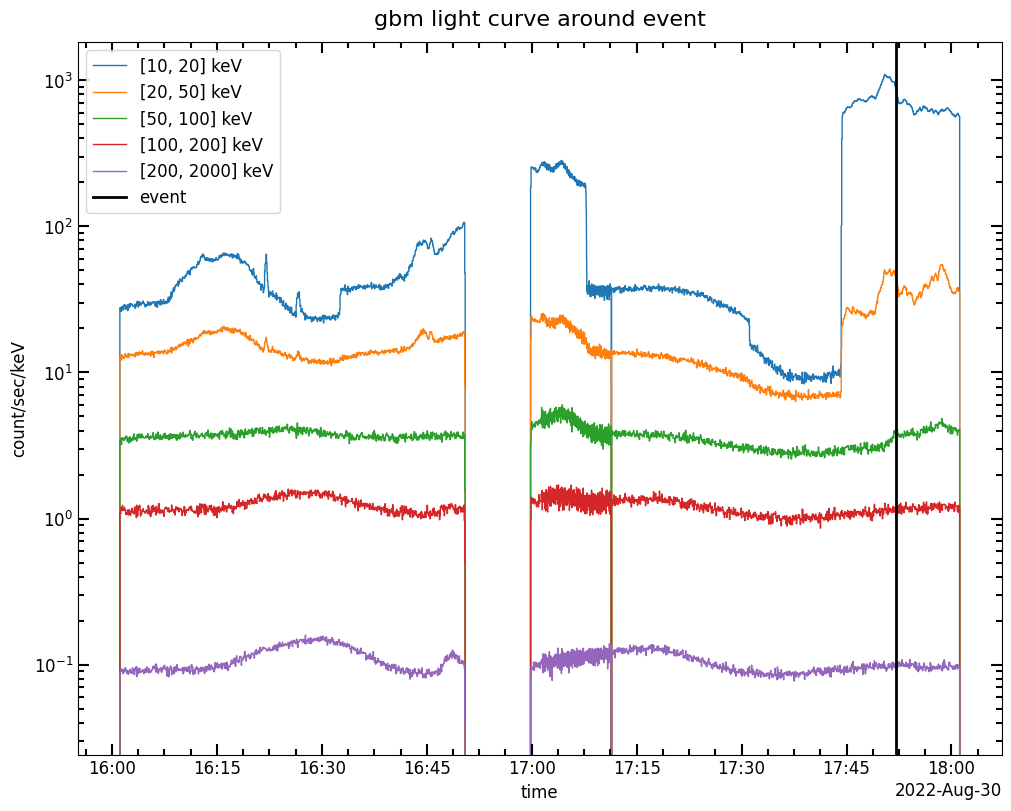

In [5]:
# Now, let's plot the light curves around the time to see what we're dealing with,
# and adjust the event time as needed.
# We also need a background segment.
start = atime.Time("2022-08-30T16:00:00")
end = atime.Time("2022-08-30T18:00:00")

fig, ax = plt.subplots(figsize=(10, 8))
energy_ranges = [[10, 20], [20, 50], [50, 100], [100, 200], [200, 2000]]
for erange in energy_ranges:
    lc = cs.to_lightcurve(
        time_range=(start.to_value("fermi"), end.to_value("fermi")),
        energy_range=erange,
    )
    tbins = atime.Time(np.concatenate((lc.lo_edges, [lc.hi_edges[-1]])), format="fermi")
    tbins.format = "isot"

    de = erange[1] - erange[0]
    ax.stairs(lc.rates / de, tbins.datetime, label=f"{erange} keV")

ax.axvline(event_time.datetime, label="event", color="black")

ax.legend()
ax.set(
    xlabel="time",
    ylabel="count/sec/keV",
    title="gbm light curve around event",
    yscale="log",
)
plt.show()

In [6]:
import gdt.core.binning.binned as binned_operations

# Sum clumps of four energy bins together to help w/ statistics
rebin_factor = 2

# Let's slice out a chunk around this time to examine
delta = 10 << u.s
event_start, event_end = (event_time - delta), (event_time + delta)
event_dat = cs.slice_time((event_start.to_value("fermi"), event_end.to_value("fermi")))
# Rebin the data to larger energy bins to help with statistics
event_dat = event_dat.rebin_energy(binned_operations.combine_by_factor, rebin_factor)

# We can take the background to be about 90 minutes before the flare,
# which corresponds to the same orbital position.
bkg_start = atime.Time("2022-08-30T16:03:00")
bkg_end = atime.Time("2022-08-30T16:03:30")
bkg_dat = cs.slice_time((bkg_start.to_value("fermi"), bkg_end.to_value("fermi")))
# Rebin the data to larger energy bins to help with statistics
bkg_dat = bkg_dat.rebin_energy(binned_operations.combine_by_factor, rebin_factor)

Now, we have sliced out the appropriate event and background data,
which we will do more with shortly.

## Step 4: get the correct response for our event time
The GBM response changes significantly as a function of time because of spacecraft maneuvering,
    so here we select the response which is interpolated across our
    analysis interval.

In [7]:
from gdt.missions.fermi.gbm.response import GbmRsp2

drm_file = f"fermi-responses/glg_cspec_{detector}_bn220830742_v00.rsp2"
srm = GbmRsp2.open(drm_file)

# The interpolated response smoothly interpolates between angular
# states of the satellite, and gives a response matrix for the time of interest.
wanted_srm = srm.interpolate(event_time.to_value("fermi"))

# Like the counts data, we need to rebin the DRM
chosen_srm = wanted_srm.rebin(factor=rebin_factor).drm

## Step 5: fit the data
Now that the rather arduous task of getting and picking data is complete,
    it's time to actually fit it.
We need to put the counts and SRM data into the appropriate format for `yaff` to interact with.

We need to take care to scale the background appropriately by the event/background effective exposures.

In [8]:
from gdt.core.data_primitives import Ebounds

# First, get the count and model energy bins
fermi_ph_bins: Ebounds = chosen_srm.photon_bins
ph_bins = (fermi_ph_bins.low_edges() + [fermi_ph_bins.high_edges()[-1]]) << u.keV
fermi_ct_bins: Ebounds = event_dat.ebounds
ct_bins = (fermi_ct_bins.low_edges() + [fermi_ct_bins.high_edges()[-1]]) << u.keV


# Next, build up the DataPacket that we need
from yaff import fitting


# Systematic error: give the fitter extra wiggle room
@u.quantity_input
def add_systematic(cts: u.ct, error: u.ct) -> u.ct:
    systematic_err = 0.05
    return np.sqrt(error**2 + (cts * systematic_err) ** 2)


cts = event_dat.data.counts.astype(np.uint).sum(axis=0) << u.ct
# Error is only Poisson from the data
cts_err = np.sqrt(cts.to_value(u.ct)) << u.ct


# Background counts need to get scaled by effective exposure
scale = event_dat.get_exposure().astype(float) / bkg_dat.get_exposure().astype(float)
bkg_cts = scale * bkg_dat.data.counts.astype(np.uint).sum(axis=0) << u.ct
bkg_err = scale * np.sqrt(bkg_cts.to_value(u.ct)) << u.ct


dp = fitting.DataPacket(
    counts=cts,
    counts_error=add_systematic(cts, cts_err),
    background_counts=bkg_cts,
    background_counts_error=add_systematic(bkg_cts, bkg_err),
    effective_exposure=(event_dat.get_exposure() << u.s),
    count_energy_edges=ct_bins,
    photon_energy_edges=ph_bins,
    # Transpose needed to match dimensions
    response_matrix=(chosen_srm.matrix.T << u.cm**2 * u.ct / u.ph),
)

In [9]:
from yaff import common_models


# We will fit a photon power law plus thermal bremsstrahlung model
def combined_model(args: dict[str, common_models.ArgsT]) -> np.ndarray:
    """The model is assumed to return units of ph/cm2/keV/s"""
    return common_models.thermal(args) + common_models.broken_power_law(args)

In [10]:
# The parameters are defined by what the model functions require
from yaff.fitting import Parameter as P, simple_bounds as B
from collections import OrderedDict

# Let's use an ODict to maintain ordering (dicts can get out of order)
parameters = OrderedDict(
    (
        # Thermal params
        ("temperature", P(30 << u.MK, frozen=False)),
        ("emission_measure", P(1 << (1e47 * u.cm**-3), frozen=False)),
        # Power law params
        ("break_energy", P(20 << u.keV, frozen=False)),
        ("upper_index", P(5 << u.one, frozen=False)),
        ("norm_flux", P(0.1 << u.ph / u.cm**2 / u.keV / u.s, frozen=False)),
        # We want these to be frozen forever
        ("norm_energy", P(20 << u.keV, frozen=True)),
        ("lower_index", P(2 << u.one, frozen=True)),
    )
)

# The prior distributions here are just parameter bounds (aka uniform)
log_priors = OrderedDict(
    (
        # Thermal params
        ("temperature", B(5, 50)),
        ("emission_measure", B(0, 1000)),
        # Power law params
        ("break_energy", B(5, 100)),
        ("lower_index", B(0, 10)),
        ("upper_index", B(2, 10)),
        ("norm_flux", B(0, 1000)),
        ("norm_energy", B(0, 100)),
    )
)

In [11]:
# Because we've added on systematic uncertainty, we must use a chi-squared likelihood
from yaff import common_likelihoods

likelihood_factory = common_likelihoods.chi_squared_factory

# Restrict the fit range to these energies
mids = dp.count_energy_mids
log_likelihood = likelihood_factory(
    restriction := ((mids >= (ea := 8)) & (mids <= (eb := 80)))
)

# Now, set up the fitter object
fr = fitting.BayesFitter(
    data=dp,
    model_function=combined_model,
    parameters=parameters,
    log_priors=log_priors,
    log_likelihood=log_likelihood,
)

In [12]:
# First, minimize parameters using Levenberg-Marquadt
fr = fitting.levenberg_minimize(fr, restriction)
fr.parameters

OrderedDict([('temperature', Parameter(3.25e+01, MK, frozen=False)),
             ('emission_measure',
              Parameter(7.51e-01, 1e+47 / cm3, frozen=False)),
             ('break_energy', Parameter(3.22e+01, keV, frozen=False)),
             ('upper_index', Parameter(6.46e+00, , frozen=False)),
             ('norm_flux',
              Parameter(4.35e-01, ph / (keV s cm2), frozen=False)),
             ('norm_energy', Parameter(2.00e+01, keV, frozen=True)),
             ('lower_index', Parameter(2.00e+00, , frozen=True))])

[(4, 400), (1, np.float64(154737.23239821423))]

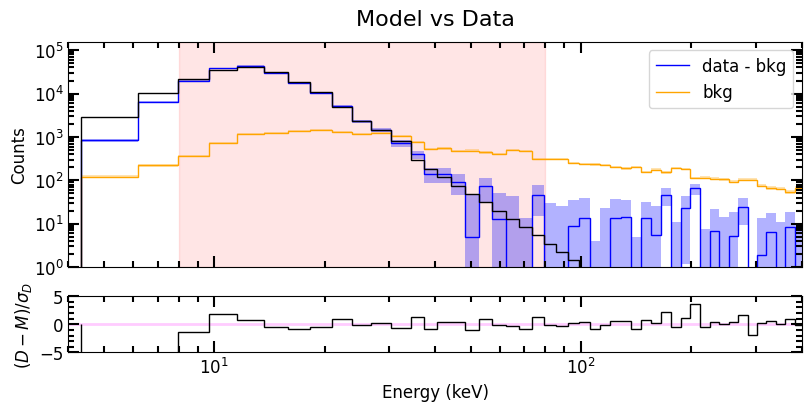

In [13]:
# Plot the initial result, and annotate the fit range
from yaff import plotting as yap

ret = yap.plot_data_model(fr)
ret["data_ax"].axvspan(ea, eb, color="red", zorder=-1, alpha=0.1)
ret["data_ax"].set(xlim=(4, 400), ylim=(1, None))

Now, we can minimize using MCMC to get a better fit to the data.

In [14]:
fr.run_emcee({"nwalkers": 20}, {"nsteps": 800})

100%|██████████| 800/800 [01:15<00:00, 10.63it/s]


{'fig': <Figure size 1000x2000 with 5 Axes>,
 'axes': [<Axes: title={'center': 'temperature'}, ylabel='MK'>,
  <Axes: title={'center': 'emission_measure'}, ylabel='1e+47 / cm3'>,
  <Axes: title={'center': 'break_energy'}, ylabel='keV'>,
  <Axes: title={'center': 'upper_index'}>,
  <Axes: title={'center': 'norm_flux'}, ylabel='ph / (keV s cm2)'>]}

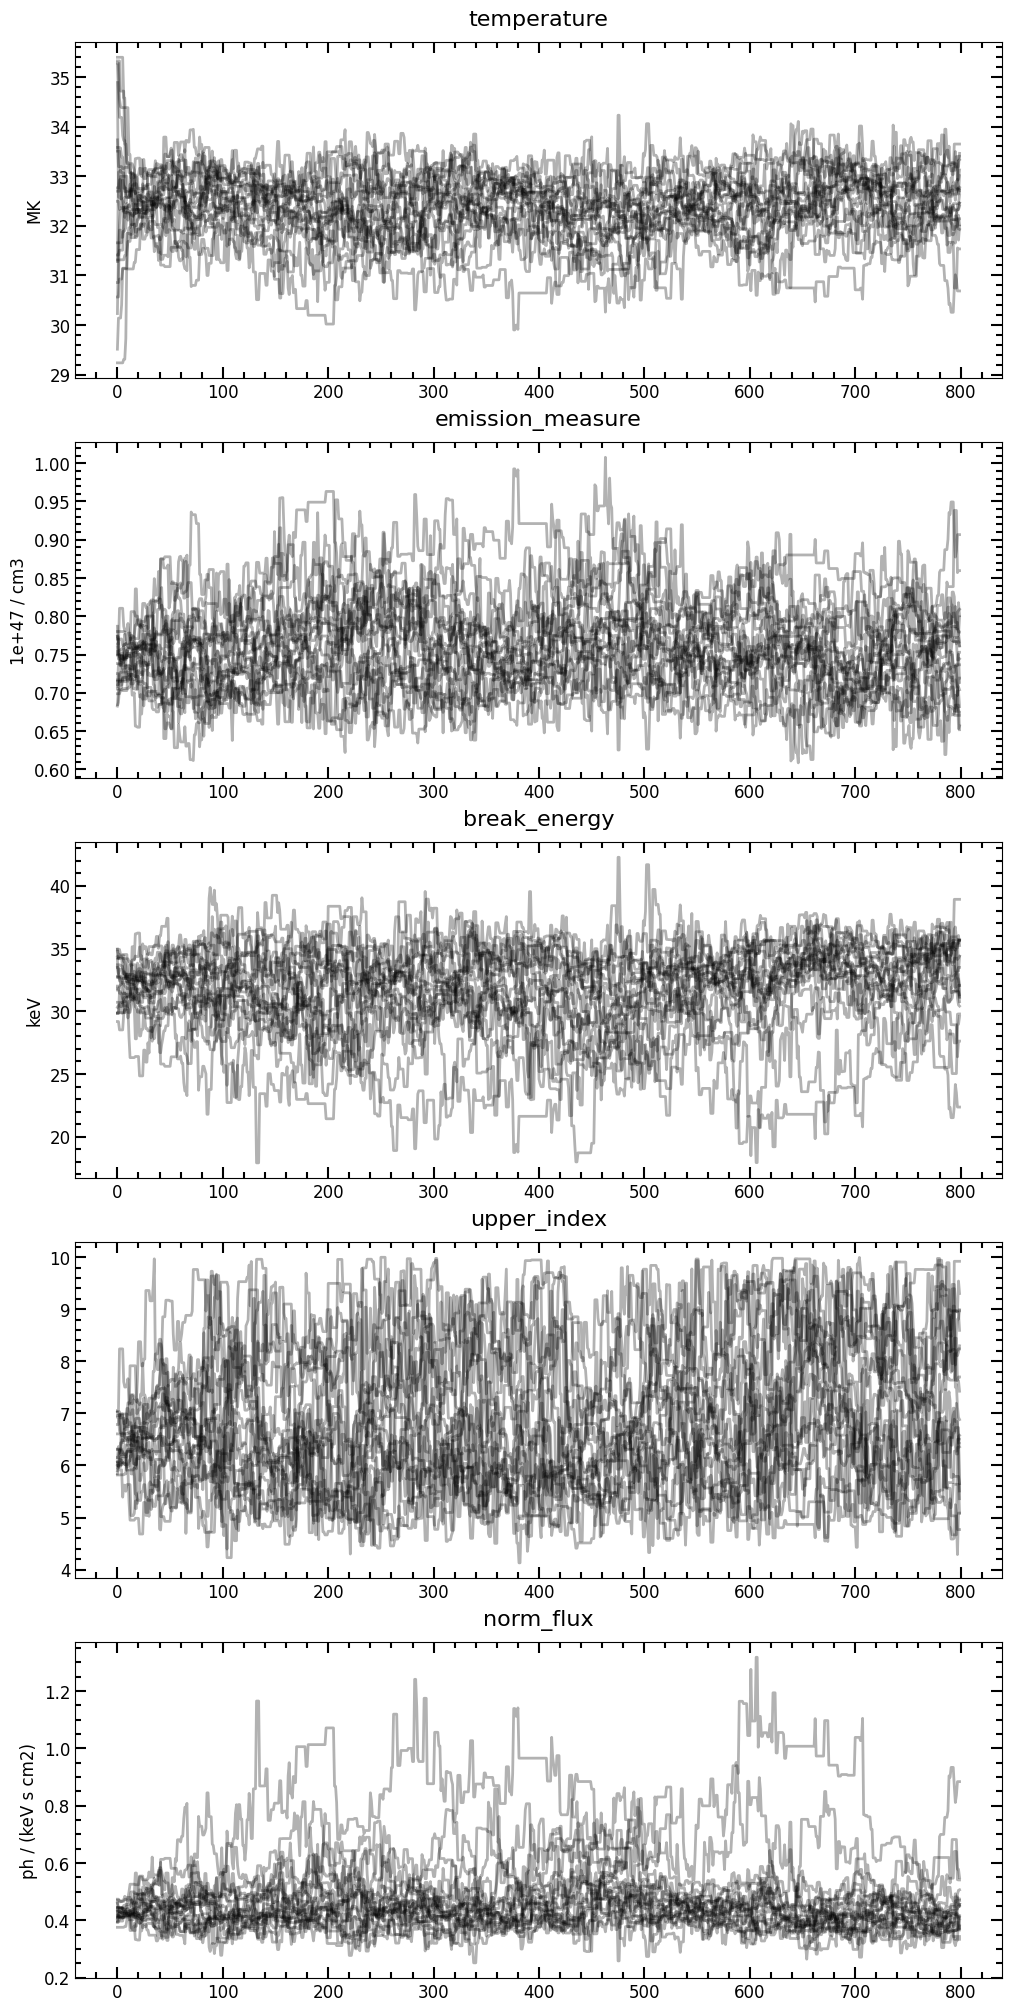

In [15]:
# Look at the parameter chains for this fit
names = fr.free_param_names
params = [fr.parameters[n] for n in names]

%matplotlib inline
fig = plt.figure(figsize=(10, 20))
yap.plot_parameter_chains(fr, names, params, fig=fig)

It looks like the important parameters have converged. Let's look at the corner plot.

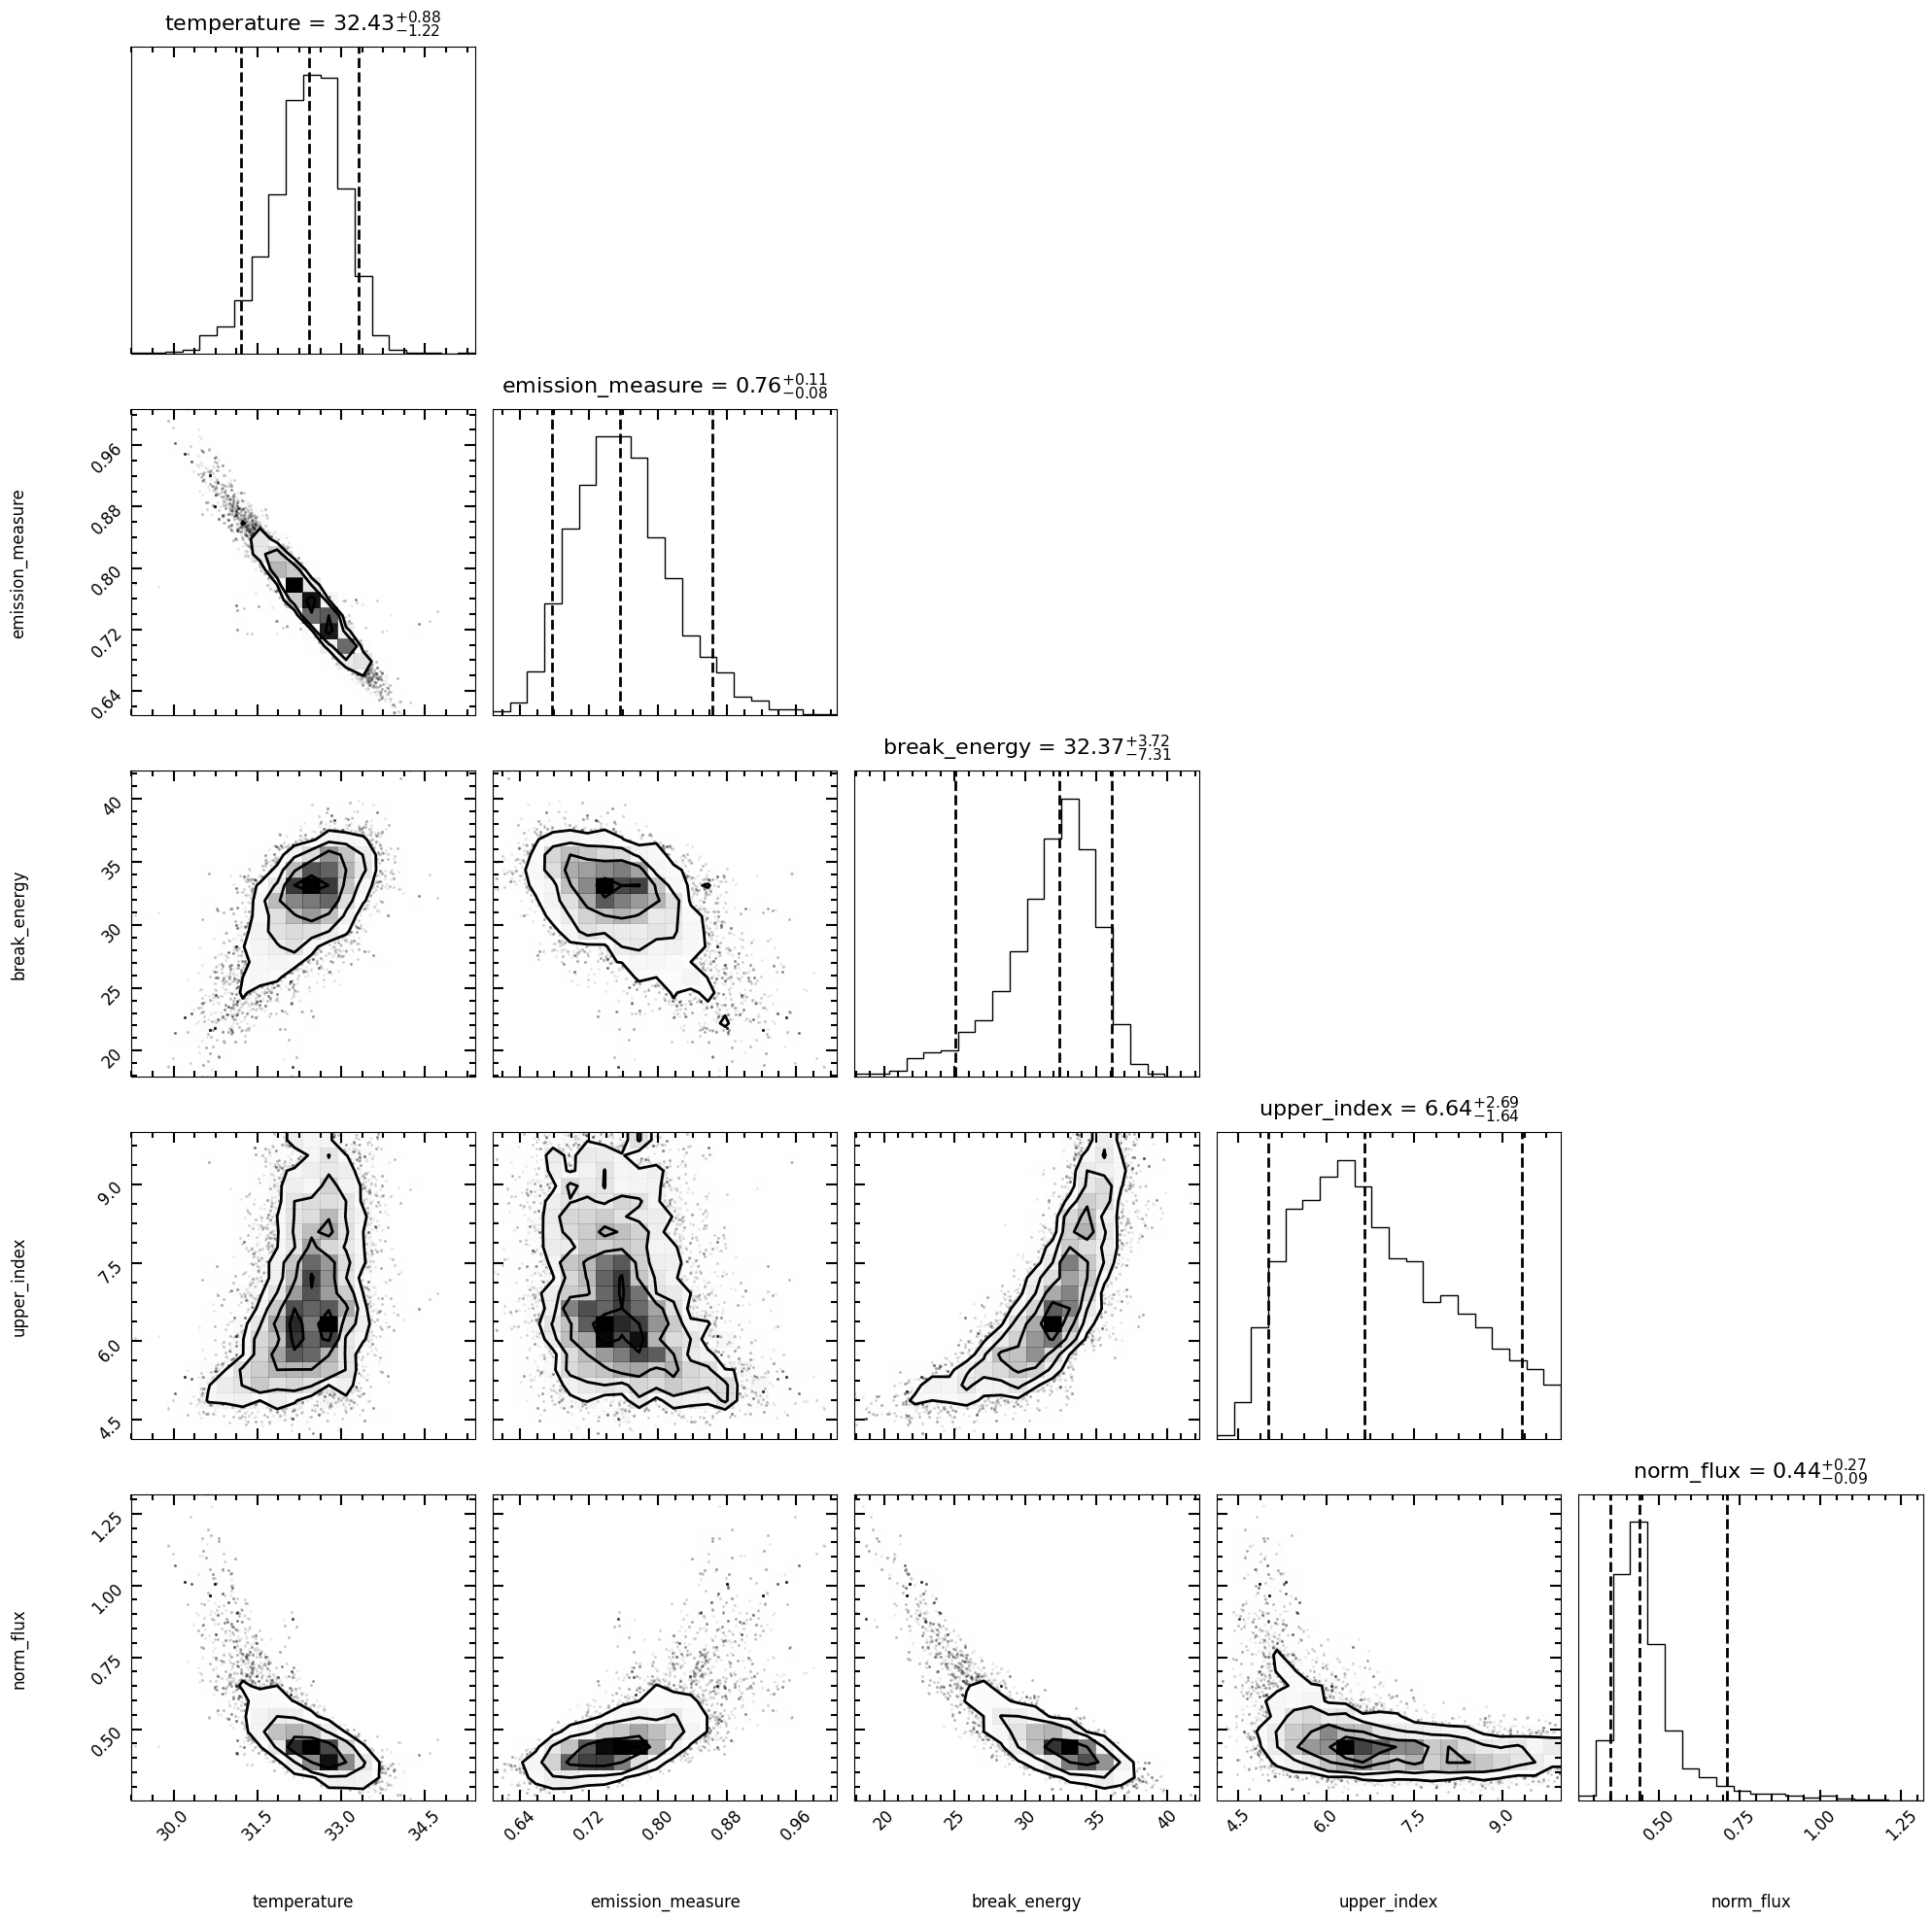

In [16]:
fig = plt.figure(figsize=(20, 20), layout="tight")
yap.corner_plot(fr, burnin=100, fig=fig)
plt.show()

Finally, plot the resulting fit on top of the data

[(0.01, 100000.0)]

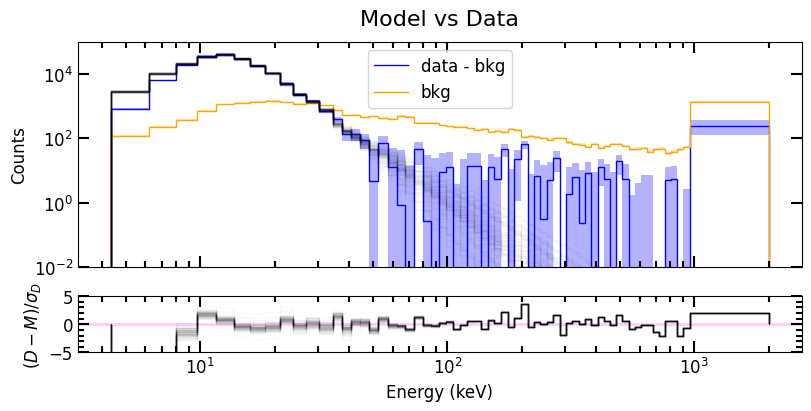

In [17]:
samples = fr.generate_model_samples(100)
ret = yap.plot_data_model(fr, samples)
ret["error_ax"].set(ylim=(-5, 5))
ret["data_ax"].set(ylim=(1e-2, 1e5))

In [18]:
# The best parameters we've found via MCMC
fr.emplace_best_mcmc()
fr.parameters

OrderedDict([('temperature', Parameter(3.24e+01, MK, frozen=False)),
             ('emission_measure',
              Parameter(7.60e-01, 1e+47 / cm3, frozen=False)),
             ('break_energy', Parameter(3.17e+01, keV, frozen=False)),
             ('upper_index', Parameter(6.85e+00, , frozen=False)),
             ('norm_flux',
              Parameter(4.69e-01, ph / (keV s cm2), frozen=False)),
             ('norm_energy', Parameter(2.00e+01, keV, frozen=True)),
             ('lower_index', Parameter(2.00e+00, , frozen=True))])

### So, we have a decent fit across lots of energies.